In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind

from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

In [4]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

In [5]:
## Load the data

with open(pickle_folder + 'movies_clean.p', 'rb') as f:
    movie_data = pickle.load(f)

In [6]:
movie_data

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Action/Adventure,Genre_Adventure,Genre_Animation,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes
0,3217,Army of Darkness,21502796.0,1992,1970-2000,12,True,True,False,False,...,False,False,False,False,False,False,False,True,7.4,197717.0
1,3333,The Birth of a Nation,50000000.0,1915,1915-1930,7,False,False,False,False,...,False,False,False,False,False,False,False,True,6.1,26681.0
2,3746,Blade Runner,33139618.0,1982,1970-2000,12,False,False,False,False,...,False,True,False,False,False,False,False,True,8.1,835060.0
3,3837,Blazing Saddles,119500000.0,1974,1970-2000,3,False,False,False,False,...,False,False,False,False,False,False,False,True,7.7,155432.0
4,3947,Blue Velvet,8551228.0,1986,1970-2000,3,False,False,False,False,...,False,False,False,False,False,False,False,True,7.7,219742.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34784,36674310,Mystery of Marie Roget,NaN,1942,1930-1950,1,False,False,False,False,...,False,False,False,False,False,False,False,True,5.9,371.0
34785,36683360,2016: Obama's America,33449086.0,2012,2000-2015,1,False,False,False,False,...,False,False,False,False,False,False,False,True,4.8,11049.0
34786,36814246,Eraserhead,7000000.0,1977,1970-2000,10,False,False,False,False,...,False,False,False,False,False,False,False,True,7.3,130107.0
34788,36929245,Before Midnight,NaN,2013,2000-2015,2,False,False,False,False,...,False,False,False,False,False,False,False,True,7.9,175072.0


**Propensity Scores**

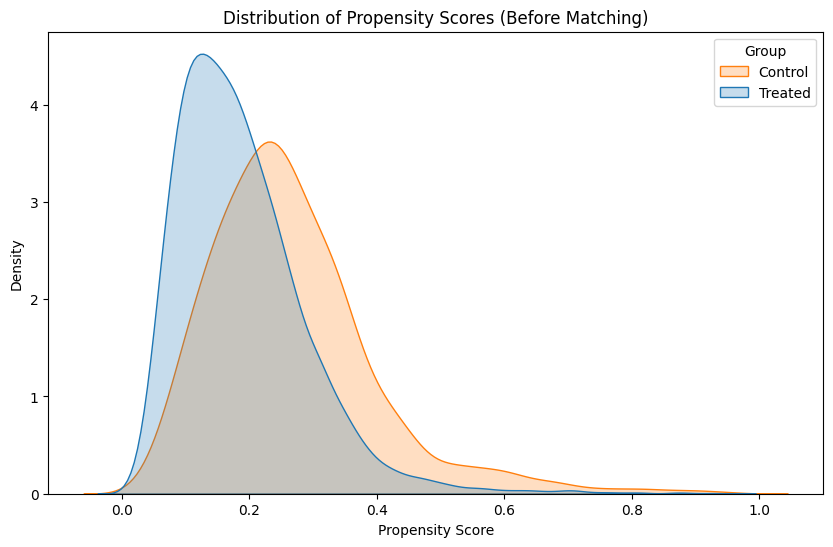

In [7]:

# prepare the data
columns_of_interest = ['Movie_box_office_revenue', 'Year', 'nb_of_Genres', 'averageRating', 'numVotes', 'nb_of_Languages']
filtered_data = movie_data[columns_of_interest].dropna()

# Define treated and control groups based on the number of languages
language_threshold = 1
filtered_data['treated'] = (filtered_data['nb_of_Languages'] > language_threshold).astype(int)

# Calculate propensity scores using logistic regression
X = filtered_data[['Year', 'nb_of_Genres', 'averageRating', 'numVotes']]
y = filtered_data['treated']

# Normalize features
X_normalized = (X - X.mean()) / X.std()

# Train logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_normalized, y)

# Add propensity scores to the dataset
filtered_data['propensity_score'] = logistic_model.predict_proba(X_normalized)[:, 1]

# Plot propensity score distributions before matching
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_data, x='propensity_score', hue='treated', fill=True, common_norm=False)
plt.title('Distribution of Propensity Scores (Before Matching)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control', 'Treated'])
plt.show()




**Matching**

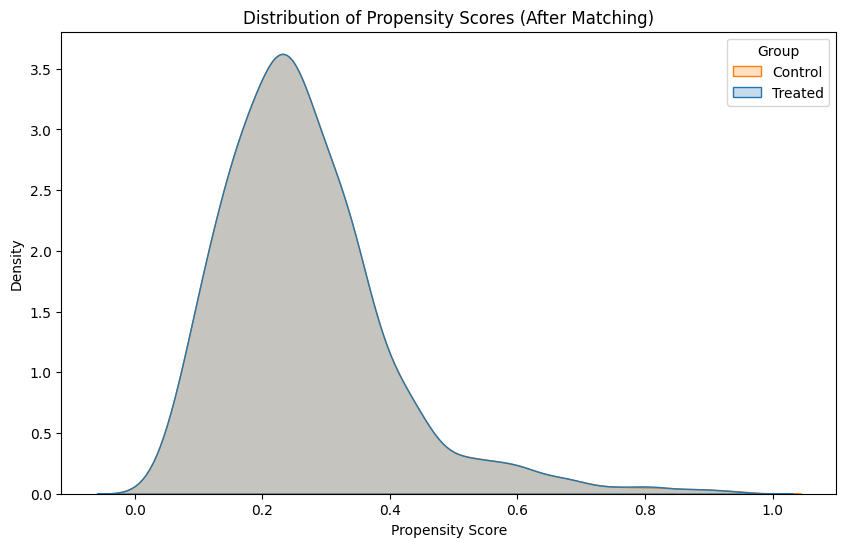

In [8]:
# Perform matching based on propensity scores
treated = filtered_data[filtered_data['treated'] == 1]
control = filtered_data[filtered_data['treated'] == 0]

# Use nearest neighbors for matching
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Apply caliper to filter matches
caliper = 0.05
matched_indices = indices[distances.flatten() < caliper]
matched_control = control.iloc[matched_indices.flatten()]
matched_treated = treated.iloc[distances.flatten() < caliper]
matched_data = pd.concat([matched_treated, matched_control])

# Plot propensity score distributions after matching
plt.figure(figsize=(10, 6))
sns.kdeplot(data=matched_data, x='propensity_score', hue='treated', fill=True, common_norm=False)
plt.title('Distribution of Propensity Scores (After Matching)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control', 'Treated'])
plt.show()



In [9]:
# Calculate average outcomes by year
years = sorted(matched_data['Year'].unique())
mean_revenues_treated = []
mean_revenues_control = []
mean_ratings_treated = []
mean_ratings_control = []

for year in years:
    # Filter data up to the current year
    subset = matched_data[matched_data['Year'] <= year]
    treated_subset = subset[subset['treated'] == 1]
    control_subset = subset[subset['treated'] == 0]
    
    # Calculate average revenue for treated and control groups
    mean_revenues_treated.append(treated_subset['Movie_box_office_revenue'].mean())
    mean_revenues_control.append(control_subset['Movie_box_office_revenue'].mean())
    
    # Calculate average rating for treated and control groups
    mean_ratings_treated.append(treated_subset['averageRating'].mean())
    mean_ratings_control.append(control_subset['averageRating'].mean())



In [10]:
# Calculate Confidence Intervals for revenue
ci_revenues_treated = []
ci_revenues_control = []

for year in years:
    subset = matched_data[matched_data['Year'] <= year]
    treated_subset = subset[subset['treated'] == 1]
    control_subset = subset[subset['treated'] == 0]

    # Calculate CI for treated group
    treated_std = treated_subset['Movie_box_office_revenue'].std()
    treated_count = len(treated_subset)
    ci_revenues_treated.append(1.96 * (treated_std / np.sqrt(treated_count)))

    # Calculate CI for control group
    control_std = control_subset['Movie_box_office_revenue'].std()
    control_count = len(control_subset)
    ci_revenues_control.append(1.96 * (control_std / np.sqrt(control_count)))

# Calculate Confidence Intervals for average rating
ci_ratings_treated = []
ci_ratings_control = []

for year in years:
    subset = matched_data[matched_data['Year'] <= year]
    treated_subset = subset[subset['treated'] == 1]
    control_subset = subset[subset['treated'] == 0]

    # Calculate CI for treated group
    treated_std = treated_subset['averageRating'].std()
    treated_count = len(treated_subset)
    ci_ratings_treated.append(1.96 * (treated_std / np.sqrt(treated_count)))

    # Calculate CI for control group
    control_std = control_subset['averageRating'].std()
    control_count = len(control_subset)
    ci_ratings_control.append(1.96 * (control_std / np.sqrt(control_count)))


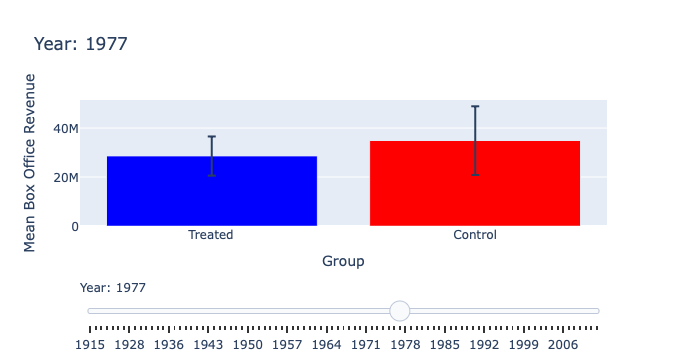

In [26]:
fig_revenue = go.Figure()

# Add bars for treated and control groups
fig_revenue.add_trace(go.Bar(
    x=['Treated', 'Control'],
    y=[mean_revenues_treated[len(years) // 2], mean_revenues_control[len(years) // 2]],  
    error_y=dict(
        type='data',
        array=[ci_revenues_treated[len(years) // 2], ci_revenues_control[len(years) // 2]],  
        visible=True
    ),
    name=f'Year: {years[len(years) // 2]}',  
    marker_color=['blue', 'red']
))

# Add a slider 
steps_revenue = []
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[
            {"y": [[mean_revenues_treated[i], mean_revenues_control[i]]],  # Update revenue data
             "error_y.array": [[ci_revenues_treated[i], ci_revenues_control[i]]]},  # Update error bars
            {"title": f"Year: {year}"}  # Update the title
        ],
        label=str(year)
    )
    steps_revenue.append(step)

sliders_revenue = [dict(
    active=len(years) // 2,  
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps_revenue
)]

fig_revenue.update_layout(
    sliders=sliders_revenue,
    title=f"Mean Box Office Revenue (Matched Samples) - Year: {years[len(years) // 2]}",
    yaxis=dict(title="Mean Box Office Revenue"),
    xaxis=dict(title="Group"),
    showlegend=False
)

fig_revenue.show()


In [12]:
#mean difference graph

mean_difference_revenue = np.abs(np.nan_to_num(np.array(mean_revenues_treated) - np.array(mean_revenues_control), nan=0))
ci_upper_revenue = np.nan_to_num(mean_difference_revenue + np.array(ci_revenues_treated) + np.array(ci_revenues_control), nan=0)
ci_lower_revenue = np.nan_to_num(mean_difference_revenue - (np.array(ci_revenues_treated) + np.array(ci_revenues_control)), nan=0)

# Define the position of the dot 
initial_index = len(years) // 2
initial_year = years[initial_index]
initial_value = mean_difference_revenue[initial_index]

# Create the figure
fig_revenue_curve = go.Figure()

# Add the main line 
fig_revenue_curve.add_trace(go.Scatter(
    x=years,
    y=mean_difference_revenue,
    mode='lines',
    name='Mean Difference (Revenue)',
    line=dict(color='blue')
))

# Add the confidence interval as a filled area
fig_revenue_curve.add_trace(go.Scatter(
    x=np.concatenate([years, years[::-1]]),
    y=np.concatenate([ci_upper_revenue, ci_lower_revenue[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 0, 255, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='95% CI'
))

# Add the red dot (initially at the middle of the curve)
fig_revenue_curve.add_trace(go.Scatter(
    x=[initial_year],
    y=[initial_value],
    mode='markers+text',
    marker=dict(color='red', size=10),
    text=[f"{initial_year}: {initial_value:.2f} USD"],
    textposition="top center",
    name="Year Marker"  
))

# Create the slider
steps_revenue_curve = []
for i, year in enumerate(years):
    step = dict(
        method='update',
        args=[
            # Update the position of the dot
            {'x': [years, np.concatenate([years, years[::-1]]), [years[i]]],
             'y': [mean_difference_revenue,
                   np.concatenate([ci_upper_revenue, ci_lower_revenue[::-1]]),
                   [mean_difference_revenue[i]]],
             'text': [None, None, [f"{years[i]}: {mean_difference_revenue[i]:.2f} USD"]]},  # Update text
        ],
        label=str(year)
    )
    steps_revenue_curve.append(step)

# Add slider configuration
fig_revenue_curve.update_layout(
    sliders=[dict(
        active=initial_index,
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        steps=steps_revenue_curve
    )],
    title="Mean Difference (Treated - Control)",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Mean Difference (USD)"),
    showlegend=True
)

# Show the figure
fig_revenue_curve.show()


In [13]:
fig_rating = go.Figure()

# Add bars for treated and control groups
fig_rating.add_trace(go.Bar(
    x=['Treated', 'Control'],
    y=[mean_ratings_treated[len(years) // 2], mean_ratings_control[len(years) // 2]],  
    error_y=dict(
        type='data',
        array=[ci_ratings_treated[len(years) // 2], ci_ratings_control[len(years) // 2]], 
        visible=True
    ),
    name=f'Year: {years[len(years) // 2]}',  
    marker_color=['blue', 'red']
))

# Add a slider
steps_rating = []
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[
            {"y": [[mean_ratings_treated[i], mean_ratings_control[i]]],  
             "error_y.array": [[ci_ratings_treated[i], ci_ratings_control[i]]]},  
            {"title": f"Year: {year}"}  
        ],
        label=str(year)
    )
    steps_rating.append(step)


sliders_rating = [dict(
    active=len(years) // 2,  
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps_rating
)]

fig_rating.update_layout(
    sliders=sliders_rating,
    title=f" Year: {years[len(years) // 2]}",  
    yaxis=dict(title="Mean Average Rating"),
    xaxis=dict(title="Group"),
    showlegend=False
)

# Display the rating graph
fig_rating.show()


In [14]:

# T-test for revenue
t_stat_revenue, p_value_revenue = ttest_ind(matched_treated['Movie_box_office_revenue'], matched_control['Movie_box_office_revenue'])
print(f"Revenue: T-statistic = {t_stat_revenue:.2f}, P-value = {p_value_revenue:.4f}")

# T-test for average rating
t_stat_rating, p_value_rating = ttest_ind(matched_treated['averageRating'], matched_control['averageRating'])
print(f"Average Rating: T-statistic = {t_stat_rating:.2f}, P-value = {p_value_rating:.4f}")


Revenue: T-statistic = 3.71, P-value = 0.0002
Average Rating: T-statistic = -0.57, P-value = 0.5701


P-value de avrg rating trop élevé, pas significatif

**ATT using DML algo (Double Machine Learning)**

In [27]:

# Define the outcome, treatment, and covariates
Y = matched_data['Movie_box_office_revenue'].values  # Outcome (Revenue)
T = matched_data['treated'].values  
X = matched_data[['Year', 'nb_of_Genres', 'averageRating', 'numVotes']]  # Covariates

# Initialize the DML model
dml = LinearDML(
    model_y=RandomForestRegressor(),  # Model for outcome regression
    model_t=RandomForestRegressor(),  # Model for treatment regression
    linear_first_stages=False
)

# Fit the model
dml.fit(Y, T, X=X, W=None)

# Estimate the treatment effect
att_dml = dml.effect(X)
print(f"Estimated ATT (Double Machine Learning): {att_dml.mean():.2f}")


Estimated ATT (Double Machine Learning): 2095687.07


Les films avec + de 1 langue generent 3821063.38 de plus que les autres 

In [25]:
"""from causalimpact import CausalImpact

# Define the data
pre_treatment = matched_data[matched_data['Year'] < 2010]
post_treatment = matched_data[matched_data['Year'] >= 2010]

data = pd.concat([
    pre_treatment['Movie_box_office_revenue'],
    post_treatment['Movie_box_office_revenue']
], axis=0)

# Define pre- and post-treatment periods
pre_period = [0, len(pre_treatment) - 1]
post_period = [len(pre_treatment), len(data) - 1]

# Apply CausalImpact
impact = CausalImpact(data.values, pre_period, post_period)
print(impact.summary())
impact.plot()"""


"from causalimpact import CausalImpact\n\n# Define the data\npre_treatment = matched_data[matched_data['Year'] < 2010]\npost_treatment = matched_data[matched_data['Year'] >= 2010]\n\ndata = pd.concat([\n    pre_treatment['Movie_box_office_revenue'],\n    post_treatment['Movie_box_office_revenue']\n], axis=0)\n\n# Define pre- and post-treatment periods\npre_period = [0, len(pre_treatment) - 1]\npost_period = [len(pre_treatment), len(data) - 1]\n\n# Apply CausalImpact\nimpact = CausalImpact(data.values, pre_period, post_period)\nprint(impact.summary())\nimpact.plot()"